### Matrix element code for CR effect: Konstantin Nesterov paper (and Ebru's thesis) : CNOT gate with Selective Darkening

$$ \langle 00|\hat{n}A|01\rangle \approx -2i \frac{J_C}{\hbar} n{01}^B \left[ \frac{(n_{01}^A)^2 \omega_{01}^A}{(\omega_{01}^A)^2 - (\omega_{01}^B)^2} + \frac{(n_{03}^A)^2 \omega_{03}^A}{(\omega_{03}^A)^2 - (\omega_{01}^B)^2} \right] $$

$$ \qquad = \frac{-2i}{\hbar} n_{01}^B \times \text{‘transmission coefficient when control is in 0’} $$

$$ \langle 10|\hat{n}A|11\rangle \approx 2i \frac{J_C}{\hbar} n{01}^B \left[ \frac{(n_{01}^A)^2 \omega_{01}^A}{(\omega_{01}^A)^2 - (\omega_{01}^B)^2} - \frac{(n_{12}^A)^2 \omega_{12}^A}{(\omega_{12}^A)^2 - (\omega_{01}^B)^2} \right] $$

$$ \qquad = \frac{-2i}{\hbar} n_{01}^B \times \text{‘transmission coefficient when control is in 1’} $$

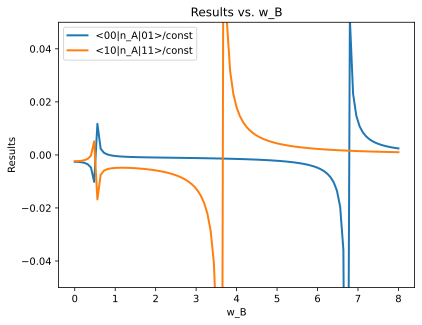

In [1]:
import scqubits as scq
import qutip as qt
import numpy as np
from matplotlib import pyplot as plt
# from qutip.qip.operations import rz, cz_gate
# import cmath

# define fluxonium A
# --- Setup qubits and Hilbert space ---
qbta = scq.Fluxonium(
    EC=1.0617, EJ=4.1933, EL=.9336, flux=0.5, cutoff=110, truncated_dim=20,
)
qbtb = scq.Transmon(
    EJ=19.98, EC=0.1845, ng=0, ncut=110, truncated_dim=20
)


#Calculating Matrix element

bare_states_a = qbta.eigenvals()-qbta.eigenvals()[0]
w_A_01 = bare_states_a[1]-bare_states_a[0]
w_A_03 = bare_states_a[3]-bare_states_a[0]
w_A_12 = bare_states_a[2]-bare_states_a[1]
Jc = .022#0.025
n_A_01 = abs(np.round(qbta.n_operator(energy_esys=True)[0][1],5))
n_A_03 = abs(np.round(qbta.n_operator(energy_esys=True)[0][3],5))
n_A_12 = abs(np.round(qbta.n_operator(energy_esys=True)[1][2],5))

bare_states_b = qbtb.eigenvals()-qbtb.eigenvals()[0]
w_B_01 = bare_states_b[1]-bare_states_b[0]
w_B_03 = bare_states_b[3]-bare_states_b[0]
w_B_12 = bare_states_b[2]-bare_states_b[1]

n_B_01 = abs(np.round(qbtb.n_operator(energy_esys=True)[0][1],5))
n_B_03 = abs(np.round(qbtb.n_operator(energy_esys=True)[0][3],5))
n_B_12 = abs(np.round(qbtb.n_operator(energy_esys=True)[1][2],5))



w_B_values = np.linspace(0, 8, 101)

# Initialize empty lists to store the results
results = []
results2 = []

# Calculate the expressions for each w_B value
for w_B in w_B_values:
    result = -2*Jc*((n_A_01**2 * w_A_01) / (w_A_01**2 - w_B**2) + (n_A_03**2 * w_A_03) / (w_A_03**2 - w_B**2))
    results.append((result))

    result2 =2*Jc*((n_A_01**2 * w_A_01) / (w_A_01**2 - w_B**2) - (n_A_12**2 * w_A_12) / (w_A_12**2 - w_B**2))
    results2.append((result2))

# Convert the results and w_B values to NumPy arrays for plotting
results = (np.array(results))
results2 = (np.array(results2))
w_B_values = np.array(w_B_values)


# Plot result vs. w_B and result2 vs. w_B on the same graph
plt.figure()
plt.plot(w_B_values, results,linewidth = 2, label='<00|n_A|01>/const')
plt.plot(w_B_values, results2,linewidth = 2, label='<10|n_A|11>/const')
plt.xlabel('w_B')
plt.ylabel('Results')
plt.ylim([-.05, .05])
plt.title('Results vs. w_B')
plt.legend()
plt.grid(False)
plt.show()

#### Now try exact numerical simualtion

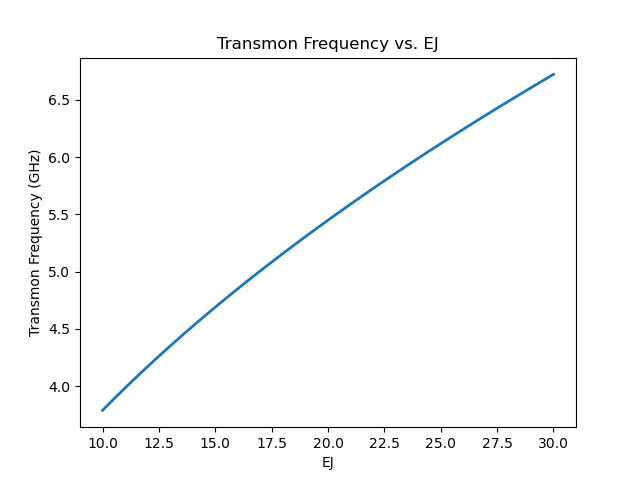

In [41]:
#check how transmon frequency changes with with changing EJ
qbtb = scq.Transmon(
    EJ=19.98, EC=0.2, ng=0, ncut=110, truncated_dim=20
)
EJ_values = np.linspace(10, 30, 101)
transmon_frequencies = []
for EJ in EJ_values:
    qbtb.EJ = EJ
    bare_states_b = qbtb.eigenvals() - qbtb.eigenvals()[0]
    transmon_frequencies.append(bare_states_b[1] - bare_states_b[0])
plt.figure()
plt.plot(EJ_values, transmon_frequencies, linewidth=2)
plt.xlabel('EJ')
plt.ylabel('Transmon Frequency (GHz)')
plt.title('Transmon Frequency vs. EJ')
plt.grid(False)
plt.show()


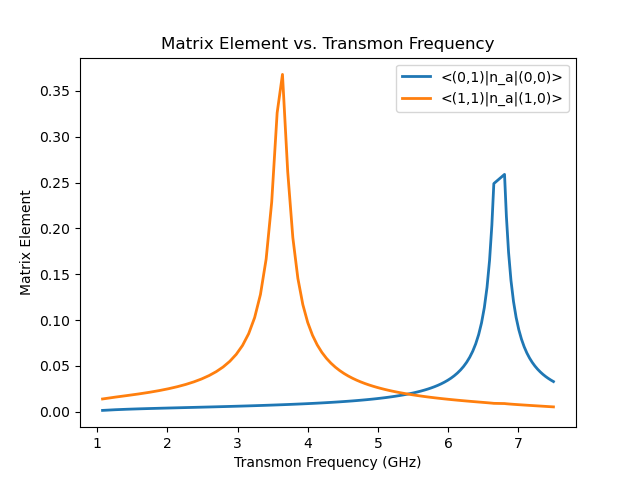

In [75]:
#Fix Jc = .022 and caclulate the matrix element for different EJ values and plot matrix element vs transmon frequency

EJ_values = np.linspace(1, 40, 101)
n_a_00_01_list = []
n_a_10_11_list = []
Jc = 0.022*5 # constant coupling strength
w_b_list = []

# --- Setup qubits and Hilbert space ---
qbta = scq.Fluxonium(
    EC=1.0617, EJ=4.1933, EL=.9336, flux=0.5, cutoff=110, truncated_dim=20,
)


for EJ in EJ_values:
    # --- Setup qubits and Hilbert space ---


    qbtb = scq.Transmon(
        EJ=EJ, EC=0.1845, ng=0, ncut=110, truncated_dim=20
    )
    hilbertspace = scq.HilbertSpace([qbta, qbtb])
    hilbertspace.add_interaction(
        g_strength=Jc, op1=qbta.n_operator, op2=qbtb.n_operator,
    )
    hilbertspace.generate_lookup()

    # --- Truncate operators ---
    total_truncation = 15
    def truncate(operator, dimension): return qt.Qobj(operator[:dimension, :dimension])
    n_a = truncate(hilbertspace.op_in_dressed_eigenbasis(qbta.n_operator), total_truncation)
    n_b = truncate(hilbertspace.op_in_dressed_eigenbasis(qbtb.n_operator), total_truncation)



    (evals,) = hilbertspace["evals"]
    diag_dressed_hamiltonian_trunc = truncate(
        2 * np.pi * qt.Qobj(np.diag(evals), dims=[hilbertspace.subsystem_dims]*2),
        total_truncation
    )
    
    def get_idx(state_tuple):
        return hilbertspace.dressed_index(state_tuple)

    idx_11 = get_idx((1,1))
    idx_10 = get_idx((1,0))
    idx_01 = get_idx((0,1))
    idx_00 = get_idx((0,0))

    w_b = evals[idx_01] - evals[idx_00]  # Frequency of the transmon in GHz
    w_b_list.append(w_b)
    # --- Calculate matrix elements ---
    
    n_a_10_11 = abs(n_a[idx_11, idx_10])  # <(1,1)|n_a|(1,0)>
    n_a_00_01 = abs(n_a[idx_01, idx_00]) # <(0,1)|n_a|(0,0)>
    
    n_a_00_01_list.append(n_a_00_01)
    n_a_10_11_list.append(n_a_10_11)

plt.figure()
plt.plot(w_b_list, n_a_00_01_list, linewidth=2, label='<(0,1)|n_a|(0,0)>')
plt.plot(w_b_list, n_a_10_11_list, linewidth=2, label='<(1,1)|n_a|(1,0)>')
plt.xlabel('Transmon Frequency (GHz)')
plt.ylabel('Matrix Element')
plt.title('Matrix Element vs. Transmon Frequency')
plt.legend()
plt.grid(False)
plt.show()




### regular CR drive


eta =  0.00575202885200322
Static_ZZ(MHz)=  0.7548610611500806
dressed_F_01(GHz)=  0.1642096004288921
dressed_F_12(GHz)=  3.54754004840987
dressed_F_03(GHz)=  5.083887787805335
dressed_T_01(GHz)=  3.9462314734039188
n_A_00_01 =  0.006550465156569264
n_A_10_11 =  0.019911839412142827
Drive amplitude f (MHz):  (3135.4544155524954+0j)


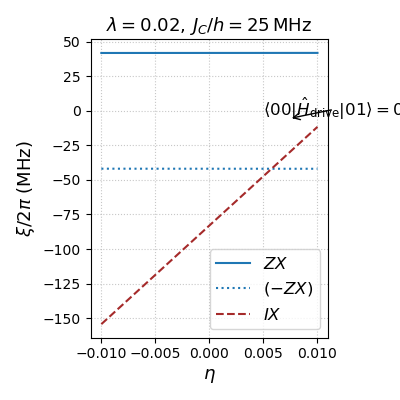

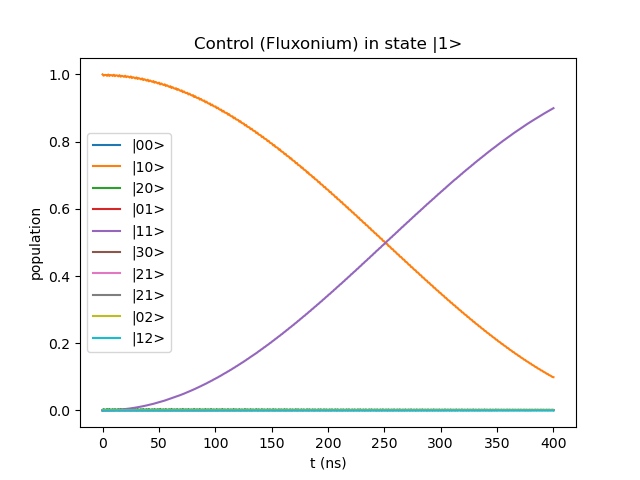

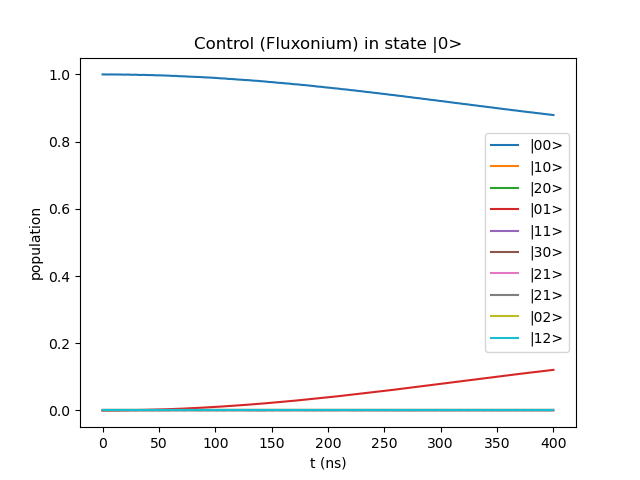

In [81]:
import scqubits as scq
import qutip as qt
import numpy as np
from matplotlib import pyplot as plt
import json

# Load parameters from JSON
with open("cr_params.json", "r") as f:
    params = json.load(f)

# Choose the set you want, e.g., "UMA5_design"
# set_name = "CR_set3_high_Jc"
# set_name = "UMA5_design"
# set_name = "FTF_FUN10_Type_3"
# set_name = "FTF_FUN10_Type_1"
set_name = "FUN5"

flux_params = params[set_name]["fluxonium"]
trans_params = params[set_name]["transmon"]
Jc = params[set_name]["Jc"]

EC_flux = flux_params["EC"]
EJ_flux = flux_params["EJ"]
EL_flux = flux_params["EL"]
EC_trans = trans_params["EC"]
EJ_trans = trans_params["EJ"]

qbta = scq.Fluxonium(
    EC=EC_flux, EJ=EJ_flux, EL=EL_flux, flux=0.5, cutoff=110, truncated_dim=20,
)
qbtb = scq.Transmon(
    EJ=EJ_trans, EC=EC_trans, ng=0, ncut=110, truncated_dim=20
)


hilbertspace = scq.HilbertSpace([qbta, qbtb])
hilbertspace.add_interaction(
    g_strength=Jc, op1=qbta.n_operator, op2=qbtb.n_operator,
)
hilbertspace.generate_lookup()

# --- Truncate operators ---
total_truncation = 40
def truncate(operator, dimension): return qt.Qobj(operator[:dimension, :dimension])
n_a = truncate(hilbertspace.op_in_dressed_eigenbasis(qbta.n_operator), total_truncation)
n_b = truncate(hilbertspace.op_in_dressed_eigenbasis(qbtb.n_operator), total_truncation)
(evals,) = hilbertspace["evals"]
diag_dressed_hamiltonian_trunc = truncate(
    2 * np.pi * qt.Qobj(np.diag(evals), dims=[hilbertspace.subsystem_dims]*2),
    total_truncation
)



evalues = (diag_dressed_hamiltonian_trunc.eigenenergies() - diag_dressed_hamiltonian_trunc.eigenenergies()[0]) / 6.28


# # convert the product states to the closes eigenstates of the dressed system
product_states_unsorted = [(0, 0), (1, 0), (0, 1),(2,0), (1, 1),(0,3) , (2,1),(0,2),(3,0), (1,2),(2,1), (2,2)]#,(4,0),(1,2),(3,1),(2,2),(5,0),(4,1),(3,2),(0,4),(1,4),(2,3),(1,3)]

idxs_unsorted = [hilbertspace.dressed_index((s1, s2)) for (s1, s2) in product_states_unsorted]

paired_data = list(zip(idxs_unsorted, product_states_unsorted))
sorted_data = sorted(paired_data, key=lambda x: x[0])
product_states = [data[1] for data in sorted_data]
idxs = [data[0] for data in sorted_data]
#sort after writing, paired data sort

states = [qt.basis(total_truncation, idx) for idx in idxs]

bare_states_a = qbta.eigenvals()-qbta.eigenvals()[0]
bare_states_b = qbtb.eigenvals()-qbtb.eigenvals()[0]

index_to_state = {idx: f'{state[0]}{state[1]}' for idx, state in zip(idxs, product_states)}
# Function to get idsx value from (i, j) tuple
def get_idx(state_tuple):
    state_string = f'{state_tuple[0]}{state_tuple[1]}'
    for idx, state_str in index_to_state.items():
        if state_str == state_string:
            return idx
    return None  # Return None if state_tuple is not found


dim=total_truncation
Omega =np.zeros((dim ,dim))
freq_tran = np.zeros((dim ,dim))
computational_subspace = states[:5] 
def transition_frequency(s0: int, s1: int) -> float:
    return (
        (
            hilbertspace.energy_by_dressed_index(s1)
            - hilbertspace.energy_by_dressed_index(s0)
        )
        * 2
        * np.pi
    )
# Nested loop for i and j
for i in range(dim):
    for j in range(i+1, dim):
        # Calculate transition energy w for each pair i, j
        w = transition_frequency(i, j)/6.28 
        Omega[i][j] = w



Delta1 = 1000*(Omega[get_idx((1,0)),get_idx((2,0))]-Omega[get_idx((1,1)),get_idx((2,1))])
Delta2 = 1000*(Omega[get_idx((1,1)),get_idx((1,2))]-Omega[get_idx((0,1)),get_idx((0,2))])
Delta3 = 1000*(Omega[get_idx((1,0)),get_idx((1,3))]-Omega[get_idx((0,0)),get_idx((0,3))])
Delta4 = 1000*(Omega[get_idx((0,1)),get_idx((3,1))]-Omega[get_idx((0,0)),get_idx((3,0))])

Static_ZZ = 1000*(Omega[get_idx((1,0)),get_idx((1,1))]-Omega[get_idx((0,0)),get_idx((0,1))]) #MHz


# print(Static_ZZ)
# print('Static_ZZ(MHz)=',Static_ZZ, 'bare_F_01 = ',bare_states_a[1],'bare_F_12 =',bare_states_a[2]-bare_states_a[1],'bare_T_01=',bare_states_b[1],'bare_F_03=',bare_states_a[3])




e_11 = evalues[hilbertspace.dressed_index((1,1))]
e_10 = evalues[hilbertspace.dressed_index((1,0))]
e_01 = evalues[hilbertspace.dressed_index((0,1))]
e_00 = evalues[hilbertspace.dressed_index((0,0))]
e_20 = evalues[hilbertspace.dressed_index((2,0))]
e_30 = evalues[hilbertspace.dressed_index((3,0))]
# e_01 = evalues[hilbertspace.dressed_index((0,1))]
# e_00 = evalues[hilbertspace.dressed_index((0,0))]

# drive_freq=Omega[get_idx((0,0)),get_idx((0,1))]
drive_freq = e_11-e_10

#drive amplitude
SD = 0
A=.05



def cosine_drive(t: float, args: dict) -> float:
    return A *np.cos(6.28*drive_freq* t)


def get_idx(state_tuple):
    return hilbertspace.dressed_index(state_tuple)

idx_11 = get_idx((1,1))
idx_10 = get_idx((1,0))
idx_01 = get_idx((0,1))
idx_00 = get_idx((0,0))
eta = np.real(-n_a[idx_00, idx_01]/n_b[idx_00, idx_01])

print('eta = ', eta)
print('Static_ZZ(MHz)= ',(e_11-e_10-e_01+e_00)*1e3)
print('dressed_F_01(GHz)= ',(e_10-e_00)*1)
print('dressed_F_12(GHz)= ',(e_20-e_10)*1)
print('dressed_F_03(GHz)= ',(e_30-e_00)*1)
print('dressed_T_01(GHz)= ',(e_01-e_00)*1)


print('n_A_00_01 = ', abs(n_a[idx_00, idx_01]))
print('n_A_10_11 = ', abs(n_a[idx_10, idx_11]))


tlist = np.linspace(0, 400, 400)
H_qbt_drive = [
    diag_dressed_hamiltonian_trunc,
    [2 * np.pi * (n_a+ eta*SD *n_b), cosine_drive],  
]


result = qt.sesolve(
    H_qbt_drive,
    qt.basis(total_truncation, hilbertspace.dressed_index(product_states[1])),
    tlist,
    e_ops=[state * state.dag() for state in states]
)
result2 = qt.sesolve(
    H_qbt_drive,
    qt.basis(total_truncation, hilbertspace.dressed_index(product_states[0])),
    tlist,
    e_ops=[state * state.dag() for state in states]
)




plt.figure()
for idx, res in zip(idxs[:10], result.expect[:10]):
    plt.plot(tlist, res, label=f"|{index_to_state[idx]}>")

plt.legend()
plt.ylabel("population")
plt.xlabel("t (ns)")
plt.title("Control (Fluxonium) in state |1>")

plt.figure()
for idx, res in zip(idxs[:10], result2.expect[:10]):
    plt.plot(tlist, res, label=f"|{index_to_state[idx]}>")

plt.legend()
plt.ylabel("population")
plt.xlabel("t (ns)")
plt.title("Control (Fluxonium) in state |0>")


n_a_bare = truncate(qbta.n_operator(energy_esys=True),5)
n_b_bare = truncate(qbtb.n_operator(energy_esys=True),5)

bare_states_a = qbta.eigenvals()-qbta.eigenvals()[0]
bare_states_b = qbtb.eigenvals()-qbtb.eigenvals()[0]

lambda_ = 0.1
w_A_01 = (bare_states_a[1]-bare_states_a[0])
w_B_01 = (bare_states_b[1]-bare_states_b[0])
Delta = (w_B_01 - w_A_01) # GHz


Omega_01 = lambda_* Delta
f = Omega_01 / 2
f = 1e3*f / (-1j*n_a_bare[0][1])  # Convert to frequency in MHz
print(f"Drive amplitude f (MHz): ", f)
f = abs(f)


sign = -1  # Sign change to match paper values

# --- Sweep eta and calculate coefficients ---
eta_values = np.linspace(-.01, 0.01, 50)
xi_ZX_list, xi_IX_list, xi_ZX_neg_list = [], [], []

def get_idx(state_tuple):
    return hilbertspace.dressed_index(state_tuple)

idx_00 = get_idx((0, 0))
idx_01 = get_idx((0, 1))
idx_10 = get_idx((1, 0))
idx_11 = get_idx((1, 1))

na_00_01 = sign* abs(-1j * n_a[idx_00, idx_01])
na_10_11 = sign* abs(-1j * n_a[idx_10, idx_11])
nb_00_01 = abs(-1j * n_b[idx_00, idx_01])
nb_10_11 = abs(-1j * n_b[idx_10, idx_11])

for eta in eta_values:
    xi_ZX = f * (na_00_01 - na_10_11) + eta * f  * (nb_00_01 - nb_10_11)
    xi_IX = f * (na_00_01 + na_10_11) + eta * f * (nb_00_01 + nb_10_11)
    xi_ZX_list.append((xi_ZX))
    xi_IX_list.append((xi_IX))
    xi_ZX_neg_list.append(-(xi_ZX))

# --- Plot ---
plt.figure(figsize=(4, 4))
plt.plot(eta_values, xi_ZX_list, label=r'$ZX$', color='C0')
plt.plot(eta_values, xi_ZX_neg_list, ':', label=r'$(-ZX)$', color='C0')
plt.plot(eta_values, xi_IX_list, '--', label=r'$IX$', color='brown')
plt.xlabel(r'$\eta$', fontsize=13)
plt.ylabel(r'$\xi/2\pi$ (MHz)', fontsize=13)
plt.title(r'$\lambda=0.02,\,J_C/h=25\,\mathrm{MHz}$', fontsize=13)

plt.legend(fontsize=12)
plt.grid(True, linestyle=':', alpha=0.7)
plt.annotate(r'$\langle 00|\hat{H}_\mathrm{drive}|01\rangle = 0$', xy=(0.00737, -5.62), xytext=(0.005, -4),
             arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=12)
plt.tight_layout()
plt.show()

### Fluxonium transition vs flux

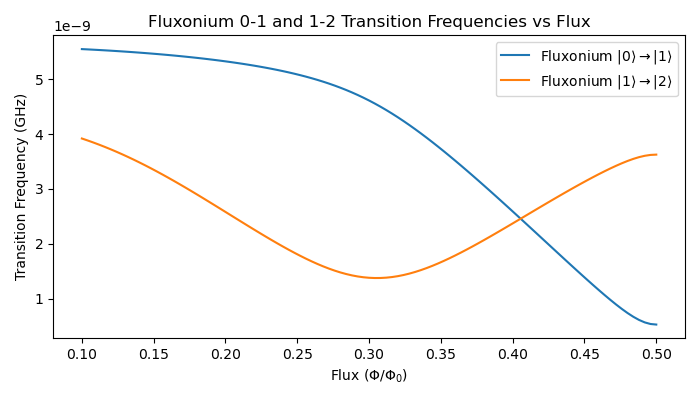

In [3]:
%matplotlib widget
import scqubits as scq
import numpy as np
import matplotlib.pyplot as plt

# Sweep flux from 0.1 to 0.5
flux_vals = np.linspace(0.1, 0.5, 101)
freq_01 = []
freq_12 = []

EC = 1.0617
EJ = 4.2
EL = 0.933
cutoff = 110
trunc = 20

for flux in flux_vals:
    qbta = scq.Fluxonium(EC=EC, EJ=EJ, EL=EL, flux=flux, cutoff=cutoff, truncated_dim=trunc)
    evals = qbta.eigenvals(evals_count=3)
    freq_01.append(evals[1] - evals[0])
    freq_12.append(evals[2] - evals[1])

plt.figure(figsize=(7,4))
plt.plot(flux_vals, np.array(freq_01)/1e9, label='Fluxonium $|0\\rangle\\rightarrow|1\\rangle$')
plt.plot(flux_vals, np.array(freq_12)/1e9, label='Fluxonium $|1\\rangle\\rightarrow|2\\rangle$')
plt.xlabel('Flux ($\Phi/\Phi_0$)')
plt.ylabel('Transition Frequency (GHz)')
plt.title('Fluxonium 0-1 and 1-2 Transition Frequencies vs Flux')
plt.legend()
plt.tight_layout()
plt.show()

### Fluxnium transitions with varying flux for the coupled system

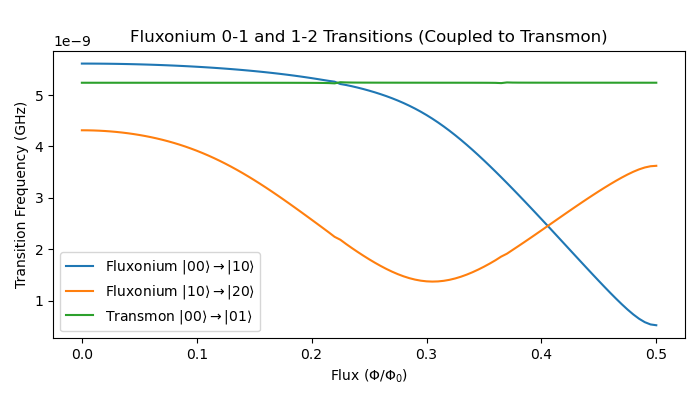

In [10]:
%matplotlib widget
import scqubits as scq
import numpy as np
import matplotlib.pyplot as plt

# Sweep flux from 0.1 to 0.5
flux_vals = np.linspace(0.0, 0.5, 101)
freq_01 = []
freq_12 = []
freq_00_01 = []

# Fixed parameters for Fluxonium and Transmon
ECa, EJa, ELa = 1.0617, 4.2, 0.933
ECb, EJb = 0.1845, 19.98
cutoff, trunc = 110, 20

for flux in flux_vals:
    # Create coupled system: Fluxonium + Transmon
    qbta = scq.Fluxonium(EC=ECa, EJ=EJa, EL=ELa, flux=flux, cutoff=cutoff, truncated_dim=trunc)
    qbtb = scq.Transmon(EJ=EJb, EC=ECb, ng=0, ncut=cutoff, truncated_dim=trunc)
    hilbertspace = scq.HilbertSpace([qbta, qbtb])
    hilbertspace.add_interaction(
        g_strength=0.0222, op1=qbta.n_operator, op2=qbtb.n_operator,
    )
    hilbertspace.generate_lookup()
    # Get lowest 3 eigenvalues of the coupled system
    evals = hilbertspace.eigenvals(evals_count=15)
    # 0-1 and 1-2 transitions of the coupled system (mostly Fluxonium-like at low energies)
    freq_01.append(evals[hilbertspace.dressed_index((1,0))] - evals[hilbertspace.dressed_index((0,0))])
    freq_12.append(evals[hilbertspace.dressed_index((2,0))] - evals[hilbertspace.dressed_index((1,0))])
    freq_00_01.append(evals[hilbertspace.dressed_index((0,1))] - evals[hilbertspace.dressed_index((0,0))])

plt.figure(figsize=(7,4))
plt.plot(flux_vals, np.array(freq_01)/1e9, label='Fluxonium $|00\\rangle\\rightarrow|10\\rangle$')
plt.plot(flux_vals, np.array(freq_12)/1e9, label='Fluxonium $|10\\rangle\\rightarrow|20\\rangle$')
plt.plot(flux_vals, np.array(freq_00_01)/1e9, label='Transmon $|00\\rangle\\rightarrow|01\\rangle$')
plt.xlabel('Flux ($\Phi/\Phi_0$)')
plt.ylabel('Transition Frequency (GHz)')
plt.title('Fluxonium 0-1 and 1-2 Transitions (Coupled to Transmon)')
plt.legend()
plt.tight_layout()
plt.show()

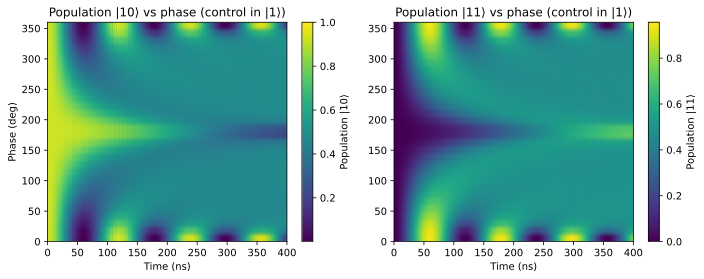

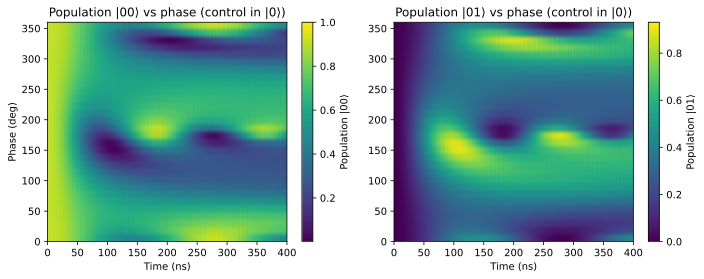

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Set eta as fixed magnitude and scan phase
eta_base = -n_a_00_01 / n_b_00_01 
eta_mag = np.abs(eta_base)
phases = np.linspace(0, 2*np.pi, 30)  # 0 to 2pi for full phase scan

pop_10 = np.zeros((len(phases), len(tlist)))
pop_11 = np.zeros((len(phases), len(tlist)))
pop_00 = np.zeros((len(phases), len(tlist)))
pop_01 = np.zeros((len(phases), len(tlist)))

idx_00 = hilbertspace.dressed_index((0,0))
idx_01 = hilbertspace.dressed_index((0,1))
idx_10 = hilbertspace.dressed_index((1,0))
idx_11 = hilbertspace.dressed_index((1,1))

for i, phi in enumerate(phases):
    eta_phase = eta_mag * np.exp(1j * phi)
    # Control in |1>
    H_qbt_drive = [
        diag_dressed_hamiltonian_trunc,
        [2 * np.pi * (n_a + eta_phase * n_b), cosine_drive],
    ]
    result = qt.sesolve(
        H_qbt_drive,
        qt.basis(total_truncation, idx_10),  # Control in |1>
        tlist,
        e_ops=[state * state.dag() for state in states]
    )
    pop_10[i, :] = result.expect[idxs.index(idx_10)]
    pop_11[i, :] = result.expect[idxs.index(idx_11)]

    # Control in |0>
    result2 = qt.sesolve(
        H_qbt_drive,
        qt.basis(total_truncation, idx_00),  # Control in |0>
        tlist,
        e_ops=[state * state.dag() for state in states]
    )
    pop_00[i, :] = result2.expect[idxs.index(idx_00)]
    pop_01[i, :] = result2.expect[idxs.index(idx_01)]

# Plot for control in |1>
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(pop_10, aspect='auto', extent=[tlist[0], tlist[-1], 0, 360], origin='lower')
plt.colorbar(label='Population |10⟩')
plt.xlabel('Time (ns)')
plt.ylabel('Phase (deg)')
plt.title('Population |10⟩ vs phase (control in |1⟩)')

plt.subplot(1,2,2)
plt.imshow(pop_11, aspect='auto', extent=[tlist[0], tlist[-1], 0, 360], origin='lower')
plt.colorbar(label='Population |11⟩')
plt.xlabel('Time (ns)')
plt.title('Population |11⟩ vs phase (control in |1⟩)')

plt.tight_layout()
plt.show()

# Plot for control in |0>
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(pop_00, aspect='auto', extent=[tlist[0], tlist[-1], 0, 360], origin='lower')
plt.colorbar(label='Population |00⟩')
plt.xlabel('Time (ns)')
plt.ylabel('Phase (deg)')
plt.title('Population |00⟩ vs phase (control in |0⟩)')

plt.subplot(1,2,2)
plt.imshow(pop_01, aspect='auto', extent=[tlist[0], tlist[-1], 0, 360], origin='lower')
plt.colorbar(label='Population |01⟩')
plt.xlabel('Time (ns)')
plt.title('Population |01⟩ vs phase (control in |0⟩)')

plt.tight_layout()
plt.show()

#### make the transmon control : not so good

0.23265645454895179
Static_ZZ(MHz)= 0.23265645454895179 bare_F_01 =  0.5279804326118658 bare_F_12 = 3.620021875606792 bare_T_01= 5.239105326612123 bare_F_03= 6.7345733516407


Text(0.5, 1.0, 'Transmon driven at Fluxonium frequency, control in |0>')

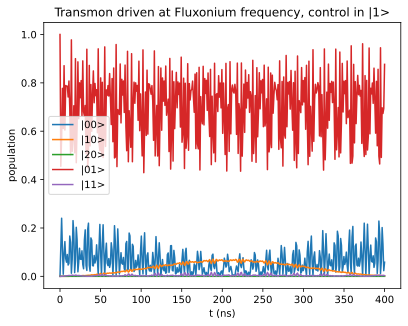

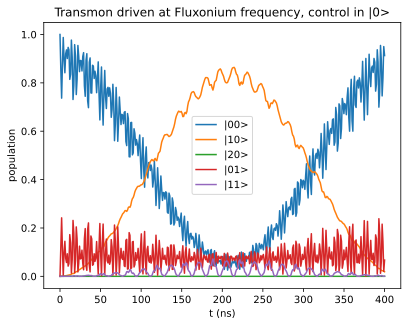

In [11]:
import scqubits as scq
import qutip as qt
import numpy as np
from matplotlib import pyplot as plt

# Define qubits
qbta = scq.Fluxonium(
    EC=1.0617,
    EJ=4.1933,
    EL=0.9336,
    flux=0.5,  # flux frustration point
    cutoff=110,
    truncated_dim=20,
)

qbtb = scq.Transmon(
    EJ=19.98,
    EC=0.1845,
    ng=0,
    ncut=110,
    truncated_dim=20
)

# Define the common Hilbert space
hilbertspace = scq.HilbertSpace([qbta, qbtb])

# Add interaction between two qubits
hilbertspace.add_interaction(
    g_strength=0.0222,
    op1=qbta.n_operator,
    op2=qbtb.n_operator,
)

# Generate spectrum lookup table
hilbertspace.generate_lookup()

# Hamiltonian in dressed eigenbasis
(evals,) = hilbertspace["evals"]
diag_dressed_hamiltonian = (
    2 * np.pi * qt.Qobj(np.diag(evals),
    dims=[hilbertspace.subsystem_dims] * 2)
)

# The matrix representations can be truncated further for the simulation
total_truncation = 15

# Truncate operators to desired dimension
def truncate(operator: qt.Qobj, dimension: int) -> qt.Qobj:
    return qt.Qobj(operator[:dimension, :dimension])

diag_dressed_hamiltonian_trunc = truncate(diag_dressed_hamiltonian, total_truncation)

evalues = (diag_dressed_hamiltonian_trunc.eigenenergies() - diag_dressed_hamiltonian_trunc.eigenenergies()[0]) / 6.28

# Get the representation of the n_a and n_b operators in the dressed eigenbasis
n_a = hilbertspace.op_in_dressed_eigenbasis(op_callable_or_tuple=qbta.n_operator)
n_b = hilbertspace.op_in_dressed_eigenbasis(op_callable_or_tuple=qbtb.n_operator)
n_a = truncate(n_a, total_truncation)
n_b = truncate(n_b, total_truncation)

# Convert the product states to the closest eigenstates of the dressed system
product_states_unsorted = [(0, 0), (1, 0), (0, 1), (2, 0), (1, 1), (0, 3), (2, 1), (0, 2), (3, 0)]
idxs_unsorted = [hilbertspace.dressed_index((s1, s2)) for (s1, s2) in product_states_unsorted]
paired_data = list(zip(idxs_unsorted, product_states_unsorted))
sorted_data = sorted(paired_data, key=lambda x: x[0])
product_states = [data[1] for data in sorted_data]
idxs = [data[0] for data in sorted_data]
states = [qt.basis(total_truncation, idx) for idx in idxs]

bare_states_a = qbta.eigenvals() - qbta.eigenvals()[0]
bare_states_b = qbtb.eigenvals() - qbtb.eigenvals()[0]

index_to_state = {idx: f'{state[0]}{state[1]}' for idx, state in zip(idxs, product_states)}

def get_idx(state_tuple):
    state_string = f'{state_tuple[0]}{state_tuple[1]}'
    for idx, state_str in index_to_state.items():
        if state_str == state_string:
            return idx
    return None

dim = total_truncation
Omega = np.zeros((dim, dim))
def transition_frequency(s0: int, s1: int) -> float:
    return (
        (
            hilbertspace.energy_by_dressed_index(s1)
            - hilbertspace.energy_by_dressed_index(s0)
        )
        * 2
        * np.pi
    )
for i in range(dim):
    for j in range(i+1, dim):
        w = transition_frequency(i, j) / 6.28
        Omega[i][j] = w

Delta1 = 1000 * (Omega[get_idx((1,0)), get_idx((2,0))] - Omega[get_idx((1,1)), get_idx((2,1))])
Delta2 = 1000 * (Omega[get_idx((1,1)), get_idx((1,2))] - Omega[get_idx((0,1)), get_idx((0,2))])
Delta3 = 1000 * (Omega[get_idx((1,0)), get_idx((1,3))] - Omega[get_idx((0,0)), get_idx((0,3))])
Delta4 = 1000 * (Omega[get_idx((0,1)), get_idx((3,1))] - Omega[get_idx((0,0)), get_idx((3,0))])
Static_ZZ = 1000 * (Omega[get_idx((1,0)), get_idx((1,1))] - Omega[get_idx((0,0)), get_idx((0,1))]) # MHz

n_diff = abs(np.round(n_a[0,2],5) - np.round(n_a[1,4],5))
n_A_01 = np.round(qbta.n_operator(energy_esys=True)[0][1],5)
bare_states_a = qbta.eigenvals() - qbta.eigenvals()[0]
bare_states_b = qbtb.eigenvals() - qbtb.eigenvals()[0]
detuning = abs(bare_states_a[1] - bare_states_b[1])
t_fsl = abs(n_A_01 * 2 * np.pi / n_diff / detuning)

print(Static_ZZ)
print('Static_ZZ(MHz)=', Static_ZZ, 'bare_F_01 = ', bare_states_a[1], 'bare_F_12 =', bare_states_a[2] - bare_states_a[1], 'bare_T_01=', bare_states_b[1], 'bare_F_03=', bare_states_a[3])

e_11 = evalues[hilbertspace.dressed_index((1,1))]
e_10 = evalues[hilbertspace.dressed_index((1,0))]
e_01 = evalues[hilbertspace.dressed_index((0,1))]
e_00 = evalues[hilbertspace.dressed_index((0,0))]
e_20 = evalues[hilbertspace.dressed_index((2,0))]
e_30 = evalues[hilbertspace.dressed_index((3,0))]

# Drive the Transmon (second qubit) at the Fluxonium frequency
fluxonium_01_freq = e_10 - e_00  # in GHz
A = .22 * 5

def cosine_drive_transmon(t: float, args: dict) -> float:
    return A * np.cos(6.28 * fluxonium_01_freq * t)

n_a_00_01 = n_a[hilbertspace.dressed_index((0,0)), hilbertspace.dressed_index((0,1))]
n_b_00_01 = n_b[hilbertspace.dressed_index((0,0)), hilbertspace.dressed_index((0,1))]

eta = 0  # No cross-drive

tlist = np.linspace(0, 400, 400)
H_qbt_drive_transmon = [
    diag_dressed_hamiltonian_trunc,
    [2 * np.pi * n_b, cosine_drive_transmon],  # Drive on Transmon at Fluxonium freq
]

result_transmon = qt.sesolve(
    H_qbt_drive_transmon,
    qt.basis(total_truncation, hilbertspace.dressed_index(product_states[3])),
    tlist,
    e_ops=[state * state.dag() for state in states]
)
result2_transmon = qt.sesolve(
    H_qbt_drive_transmon,
    qt.basis(total_truncation, hilbertspace.dressed_index(product_states[0])),
    tlist,
    e_ops=[state * state.dag() for state in states]
)

plt.figure()
for idx, res in zip(idxs[:5], result_transmon.expect[:5]):
    plt.plot(tlist, res, label=f"|{index_to_state[idx]}>")
plt.legend()
plt.ylabel("population")
plt.xlabel("t (ns)")
plt.title("Transmon driven at Fluxonium frequency, control in |1>")

plt.figure()
for idx, res in zip(idxs[:5], result2_transmon.expect[:5]):
    plt.plot(tlist, res, label=f"|{index_to_state[idx]}>")
plt.legend()
plt.ylabel("population")
plt.xlabel("t (ns)")
plt.title("Transmon driven at Fluxonium frequency, control in |0>")

#### put the phase inside cosine

0.10254266091447306
Static_ZZ(MHz)= 0.10254266091447306 bare_F_01 =  0.7371177268660387 bare_F_12 = 3.5048086444576896 bare_T_01= 5.239105326612123 bare_F_03= 6.845202062161327
Static_ZZ(MHz)=  0.10254266091536124
dressed_F_01(GHz)=  0.7374740169155866
dressed_F_12(GHz)=  3.506389855003683
dressed_F_03(GHz)=  6.848584478627697
dressed_T_01(GHz)=  5.241730861043673


Text(0.5, 1.0, 'Both drives: Fluxonium and Transmon with different phases, control in |0>')

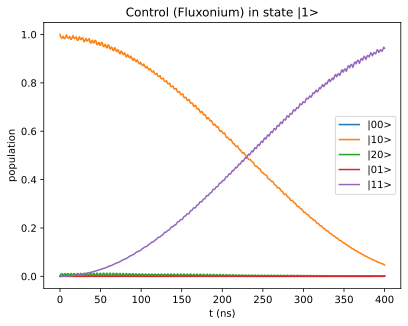

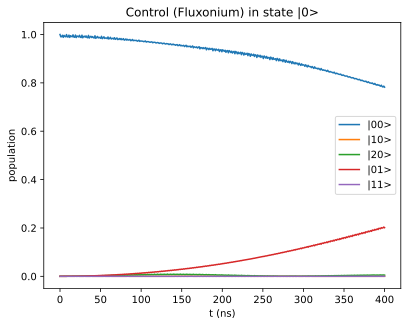

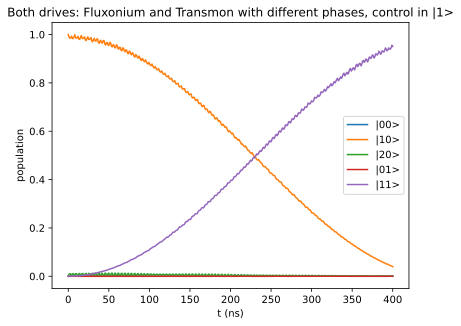

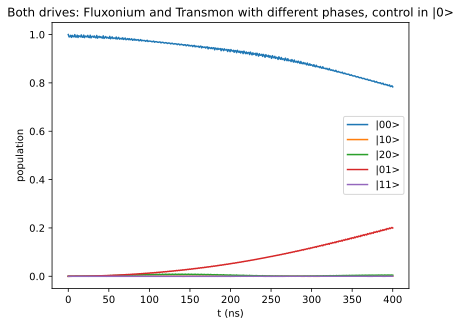

In [ ]:
import scqubits as scq
import qutip as qt
import numpy as np
from matplotlib import pyplot as plt


qbta = scq.Fluxonium(
    EC=1.0617,
    EJ = 4.1933,
    EL=.9336,
    flux=0.52,  # flux frustration point
    cutoff=110,
    truncated_dim=20,
)


qbtb = scq.Transmon(
     EJ=19.98,
     EC=0.1845,
     ng=0,
     ncut=110,
     truncated_dim=20)


# define the common Hilbert space
hilbertspace = scq.HilbertSpace([qbta, qbtb])


# add interaction between two qubits
hilbertspace.add_interaction(
    g_strength=0.0222,
    op1=qbta.n_operator,
    op2=qbtb.n_operator,
)


# generate spectrum lookup table
hilbertspace.generate_lookup()

# Hamiltonian in dressed eigenbasis
(evals,) = hilbertspace["evals"]
# The factor of 2pi converts the energy to GHz so that the time is in units of ns
diag_dressed_hamiltonian = (
        2 * np.pi * qt.Qobj(np.diag(evals),
        dims=[hilbertspace.subsystem_dims] * 2)
)

# The matrix representations can be truncated further for the simulation
total_truncation = 15

# truncate operators to desired dimension
def truncate(operator: qt.Qobj, dimension: int) -> qt.Qobj:
    return qt.Qobj(operator[:dimension, :dimension])

diag_dressed_hamiltonian_trunc = truncate(diag_dressed_hamiltonian, total_truncation)

evalues = (diag_dressed_hamiltonian_trunc.eigenenergies()-diag_dressed_hamiltonian_trunc.eigenenergies()[0])/6.28


# get the representation of the n_a operator in the dressed eigenbasis of the composite system

n_a = hilbertspace.op_in_dressed_eigenbasis(op_callable_or_tuple=qbta.n_operator)
n_b = hilbertspace.op_in_dressed_eigenbasis(op_callable_or_tuple=qbtb.n_operator)
# truncate the operator after expressing in the dressed basis to speed up the simulation
n_a = truncate(n_a, total_truncation)
n_b = truncate(n_b, total_truncation)

# # convert the product states to the closes eigenstates of the dressed system
product_states_unsorted = [(0, 0), (1, 0), (0, 1),(2,0), (1, 1),(0,3) , (2,1),(0,2),(3,0)]#,(4,0),(1,2),(3,1),(2,2),(5,0),(4,1),(3,2),(0,4),(1,4),(2,3),(1,3)]

idxs_unsorted = [hilbertspace.dressed_index((s1, s2)) for (s1, s2) in product_states_unsorted]

paired_data = list(zip(idxs_unsorted, product_states_unsorted))
sorted_data = sorted(paired_data, key=lambda x: x[0])
product_states = [data[1] for data in sorted_data]
idxs = [data[0] for data in sorted_data]
#sort after writing, paired data sort

states = [qt.basis(total_truncation, idx) for idx in idxs]

bare_states_a = qbta.eigenvals()-qbta.eigenvals()[0]
bare_states_b = qbtb.eigenvals()-qbtb.eigenvals()[0]

index_to_state = {idx: f'{state[0]}{state[1]}' for idx, state in zip(idxs, product_states)}
# Function to get idsx value from (i, j) tuple
def get_idx(state_tuple):
    state_string = f'{state_tuple[0]}{state_tuple[1]}'
    for idx, state_str in index_to_state.items():
        if state_str == state_string:
            return idx
    return None  # Return None if state_tuple is not found


dim=total_truncation
Omega =np.zeros((dim ,dim))
freq_tran = np.zeros((dim ,dim))
computational_subspace = states[:5] 
def transition_frequency(s0: int, s1: int) -> float:
    return (
        (
            hilbertspace.energy_by_dressed_index(s1)
            - hilbertspace.energy_by_dressed_index(s0)
        )
        * 2
        * np.pi
    )
# Nested loop for i and j
for i in range(dim):
    for j in range(i+1, dim):
        # Calculate transition energy w for each pair i, j
        w = transition_frequency(i, j)/6.28 
        Omega[i][j] = w



Delta1 = 1000*(Omega[get_idx((1,0)),get_idx((2,0))]-Omega[get_idx((1,1)),get_idx((2,1))])
Delta2 = 1000*(Omega[get_idx((1,1)),get_idx((1,2))]-Omega[get_idx((0,1)),get_idx((0,2))])
Delta3 = 1000*(Omega[get_idx((1,0)),get_idx((1,3))]-Omega[get_idx((0,0)),get_idx((0,3))])
Delta4 = 1000*(Omega[get_idx((0,1)),get_idx((3,1))]-Omega[get_idx((0,0)),get_idx((3,0))])

Static_ZZ = 1000*(Omega[get_idx((1,0)),get_idx((1,1))]-Omega[get_idx((0,0)),get_idx((0,1))]) #MHz









n_diff = abs(np.round(n_a[0,2],5)-np.round(n_a[1,4],5))
n_A_01 = np.round(qbta.n_operator(energy_esys=True)[0][1],5)

bare_states_a = qbta.eigenvals()-qbta.eigenvals()[0]
bare_states_b = qbtb.eigenvals()-qbtb.eigenvals()[0]
detuning  = abs(bare_states_a[1]-bare_states_b[1])

t_fsl = abs(n_A_01*2*np.pi/n_diff/detuning)


print(Static_ZZ)
print('Static_ZZ(MHz)=',Static_ZZ, 'bare_F_01 = ',bare_states_a[1],'bare_F_12 =',bare_states_a[2]-bare_states_a[1],'bare_T_01=',bare_states_b[1],'bare_F_03=',bare_states_a[3])




e_11 = evalues[hilbertspace.dressed_index((1,1))]
e_10 = evalues[hilbertspace.dressed_index((1,0))]
e_01 = evalues[hilbertspace.dressed_index((0,1))]
e_00 = evalues[hilbertspace.dressed_index((0,0))]
e_20 = evalues[hilbertspace.dressed_index((2,0))]
e_30 = evalues[hilbertspace.dressed_index((3,0))]
# e_01 = evalues[hilbertspace.dressed_index((0,1))]
# e_00 = evalues[hilbertspace.dressed_index((0,0))]

# drive_freq=Omega[get_idx((0,0)),get_idx((0,1))]
drive_freq = e_01-e_00 
A=.22*2
def cosine_drive(t: float, args: dict) -> float:
    return A *np.cos(6.28*drive_freq* t)

n_a_00_01 = n_a[hilbertspace.dressed_index((0,0)),hilbertspace.dressed_index((0,1))]
n_b_00_01 = n_b[hilbertspace.dressed_index((0,0)),hilbertspace.dressed_index((0,1))]

eta = -n_a_00_01/n_b_00_01 


print('Static_ZZ(MHz)= ',(e_11-e_10-e_01+e_00)*1e3)
print('dressed_F_01(GHz)= ',(e_10-e_00)*1)
print('dressed_F_12(GHz)= ',(e_20-e_10)*1)
print('dressed_F_03(GHz)= ',(e_30-e_00)*1)
print('dressed_T_01(GHz)= ',(e_01-e_00)*1)

tlist = np.linspace(0, 400, 400)
H_qbt_drive = [
    diag_dressed_hamiltonian_trunc,
    [2 * np.pi * (n_a+eta*n_b), cosine_drive],  
]


result = qt.sesolve(
    H_qbt_drive,
    qt.basis(total_truncation, hilbertspace.dressed_index(product_states[1])),
    tlist,
    e_ops=[state * state.dag() for state in states]
)
result2 = qt.sesolve(
    H_qbt_drive,
    qt.basis(total_truncation, hilbertspace.dressed_index(product_states[0])),
    tlist,
    e_ops=[state * state.dag() for state in states]
)




plt.figure()
for idx, res in zip(idxs[:5], result.expect[:5]):
    plt.plot(tlist, res, label=f"|{index_to_state[idx]}>")

plt.legend()
plt.ylabel("population")
plt.xlabel("t (ns)")
plt.title("Control (Fluxonium) in state |1>")

plt.figure()
for idx, res in zip(idxs[:5], result2.expect[:5]):
    plt.plot(tlist, res, label=f"|{index_to_state[idx]}>")

plt.legend()
plt.ylabel("population")
plt.xlabel("t (ns)")
plt.title("Control (Fluxonium) in state |0>")




# ...existing code...

# Define drive amplitudes and phases for each qubit
A_fluxonium = .22 * 2
A_transmon = .22 * 2
phase_fluxonium = 0.0            # in radians
phase_transmon = np.pi     # example: 90 degrees phase difference

# Define drive frequencies
drive_freq_fluxonium = e_11 - e_10   # Fluxonium |0>→|1> transition
drive_freq_transmon = e_11 - e_10    # Transmon |0>→|1> transition (or use desired freq)

# Define drive functions with phase
def cosine_drive_fluxonium(t: float, args: dict) -> float:
    return A_fluxonium * np.cos(6.28 * drive_freq_fluxonium * t + phase_fluxonium)

def cosine_drive_transmon(t: float, args: dict) -> float:
    return A_transmon * np.cos(6.28 * drive_freq_transmon * t + phase_transmon)

# Example: drive both with different phases
H_qbt_drive_phased = [
    diag_dressed_hamiltonian_trunc,
    [2 * np.pi * n_a, cosine_drive_fluxonium],
    [2 * np.pi * n_b*eta, cosine_drive_transmon],
]

result = qt.sesolve(
    H_qbt_drive_phased,
    qt.basis(total_truncation, hilbertspace.dressed_index(product_states[1])),
    tlist,
    e_ops=[state * state.dag() for state in states]
)
result2 = qt.sesolve(
    H_qbt_drive_phased,
    qt.basis(total_truncation, hilbertspace.dressed_index(product_states[0])),
    tlist,
    e_ops=[state * state.dag() for state in states]
)

plt.figure()
for idx, res in zip(idxs[:5], result.expect[:5]):
    plt.plot(tlist, res, label=f"|{index_to_state[idx]}>")
plt.legend()
plt.ylabel("population")
plt.xlabel("t (ns)")
plt.title("Both drives: Fluxonium and Transmon with different phases, control in |1>")

plt.figure()
for idx, res in zip(idxs[:5], result2.expect[:5]):
    plt.plot(tlist, res, label=f"|{index_to_state[idx]}>")
plt.legend()
plt.ylabel("population")
plt.xlabel("t (ns)")
plt.title("Both drives: Fluxonium and Transmon with different phases, control in |0>")
# ...existing code...

(0.0025422641975246154+1.8896484527583984e-16j)


Text(0.5, 1.0, 'Control (Fluxonium) in state |0>')

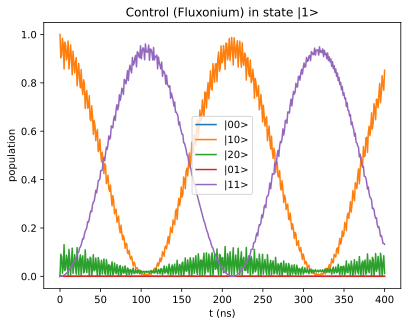

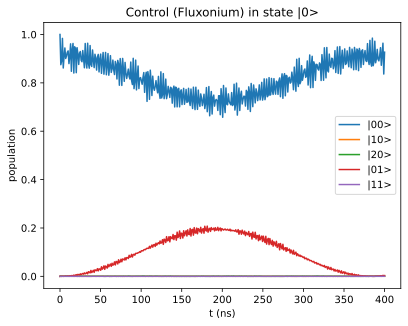

In [33]:
## Drive transmon with transmon drive vs fluxonium ccharge line

import scqubits as scq
import qutip as qt
import numpy as np
from matplotlib import pyplot as plt


qbta = scq.Fluxonium(
    EC=1.0617,
    EJ = 4.1933,
    EL=.9336,
    flux=0.5,  # flux frustration point
    cutoff=110,
    truncated_dim=20,
)


qbtb = scq.Transmon(
     EJ=19.98,
     EC=0.1845,
     ng=0,
     ncut=110,
     truncated_dim=20)


# define the common Hilbert space
hilbertspace = scq.HilbertSpace([qbta, qbtb])


# add interaction between two qubits
hilbertspace.add_interaction(
    g_strength=0.0222,
    op1=qbta.n_operator,
    op2=qbtb.n_operator,
)


# generate spectrum lookup table
hilbertspace.generate_lookup()

# Hamiltonian in dressed eigenbasis
(evals,) = hilbertspace["evals"]
# The factor of 2pi converts the energy to GHz so that the time is in units of ns
diag_dressed_hamiltonian = (
        2 * np.pi * qt.Qobj(np.diag(evals),
        dims=[hilbertspace.subsystem_dims] * 2)
)

# The matrix representations can be truncated further for the simulation
total_truncation = 15

# truncate operators to desired dimension
def truncate(operator: qt.Qobj, dimension: int) -> qt.Qobj:
    return qt.Qobj(operator[:dimension, :dimension])

diag_dressed_hamiltonian_trunc = truncate(diag_dressed_hamiltonian, total_truncation)

evalues = (diag_dressed_hamiltonian_trunc.eigenenergies()-diag_dressed_hamiltonian_trunc.eigenenergies()[0])/6.28


# get the representation of the n_a operator in the dressed eigenbasis of the composite system
n_a = hilbertspace.op_in_dressed_eigenbasis(op_callable_or_tuple=qbta.n_operator)
n_b = hilbertspace.op_in_dressed_eigenbasis(op_callable_or_tuple=qbtb.n_operator)
# truncate the operator after expressing in the dressed basis to speed up the simulation
n_a = truncate(n_a, total_truncation)
n_b = truncate(n_b, total_truncation)

# # convert the product states to the closes eigenstates of the dressed system
product_states_unsorted = [(0, 0), (1, 0), (0, 1),(2,0), (1, 1),(0,3) , (2,1),(0,2),(3,0)]#,(4,0),(1,2),(3,1),(2,2),(5,0),(4,1),(3,2),(0,4),(1,4),(2,3),(1,3)]

idxs_unsorted = [hilbertspace.dressed_index((s1, s2)) for (s1, s2) in product_states_unsorted]

paired_data = list(zip(idxs_unsorted, product_states_unsorted))
sorted_data = sorted(paired_data, key=lambda x: x[0])
product_states = [data[1] for data in sorted_data]
idxs = [data[0] for data in sorted_data]
#sort after writing, paired data sort

states = [qt.basis(total_truncation, idx) for idx in idxs]

bare_states_a = qbta.eigenvals()-qbta.eigenvals()[0]
bare_states_b = qbtb.eigenvals()-qbtb.eigenvals()[0]




index_to_state = {idx: f'{state[0]}{state[1]}' for idx, state in zip(idxs, product_states)}
# Function to get idsx value from (i, j) tuple
def get_idx(state_tuple):
    state_string = f'{state_tuple[0]}{state_tuple[1]}'
    for idx, state_str in index_to_state.items():
        if state_str == state_string:
            return idx
    return None  # Return None if state_tuple is not found


dim=total_truncation
Omega =np.zeros((dim ,dim))
freq_tran = np.zeros((dim ,dim))
computational_subspace = states[:5] 
def transition_frequency(s0: int, s1: int) -> float:
    return (
        (
            hilbertspace.energy_by_dressed_index(s1)
            - hilbertspace.energy_by_dressed_index(s0)
        )
        * 2
        * np.pi
    )
# Nested loop for i and j
for i in range(dim):
    for j in range(i+1, dim):
        # Calculate transition energy w for each pair i, j
        w = transition_frequency(i, j)/6.28 
        Omega[i][j] = w



Delta1 = 1000*(Omega[get_idx((1,0)),get_idx((2,0))]-Omega[get_idx((1,1)),get_idx((2,1))])
Delta2 = 1000*(Omega[get_idx((1,1)),get_idx((1,2))]-Omega[get_idx((0,1)),get_idx((0,2))])
Delta3 = 1000*(Omega[get_idx((1,0)),get_idx((1,3))]-Omega[get_idx((0,0)),get_idx((0,3))])
Delta4 = 1000*(Omega[get_idx((0,1)),get_idx((3,1))]-Omega[get_idx((0,0)),get_idx((3,0))])

Static_ZZ = 1000*(Omega[get_idx((1,0)),get_idx((1,1))]-Omega[get_idx((0,0)),get_idx((0,1))]) #MHz

e_11 = evalues[hilbertspace.dressed_index((1,1))]
e_10 = evalues[hilbertspace.dressed_index((1,0))]
e_01 = evalues[hilbertspace.dressed_index((0,1))]
e_00 = evalues[hilbertspace.dressed_index((0,0))]
e_20 = evalues[hilbertspace.dressed_index((2,0))]
e_30 = evalues[hilbertspace.dressed_index((3,0))]
# e_01 = evalues[hilbertspace.dressed_index((0,1))]
# e_00 = evalues[hilbertspace.dressed_index((0,0))]

# drive_freq=Omega[get_idx((0,0)),get_idx((0,1))]
drive_freq = e_01-e_00

#drive amplitude
A=.22*5



def cosine_drive(t: float, args: dict) -> float:
    return A *np.cos(6.28*drive_freq* t)

n_a_00_01 = n_a[hilbertspace.dressed_index((0,0)),hilbertspace.dressed_index((0,1))]
n_b_00_01 = n_b[hilbertspace.dressed_index((0,0)),hilbertspace.dressed_index((0,1))]

eta = -n_a_00_01/n_b_00_01
print(eta)




tlist = np.linspace(0, 400, 400)


H_qbt_drive = [
    diag_dressed_hamiltonian_trunc,
    [2 * np.pi * (n_a), cosine_drive],  
]


result = qt.sesolve(
    H_qbt_drive,
    qt.basis(total_truncation, hilbertspace.dressed_index(product_states[1])),
    tlist,
    e_ops=[state * state.dag() for state in states]
)
result2 = qt.sesolve(
    H_qbt_drive,
    qt.basis(total_truncation, hilbertspace.dressed_index(product_states[0])),
    tlist,
    e_ops=[state * state.dag() for state in states]
)




plt.figure()
for idx, res in zip(idxs[:5], result.expect[:5]):
    plt.plot(tlist, res, label=f"|{index_to_state[idx]}>")

plt.legend()
plt.ylabel("population")
plt.xlabel("t (ns)")
plt.title("Control (Fluxonium) in state |1>")

plt.figure()
for idx, res in zip(idxs[:5], result2.expect[:5]):
    plt.plot(tlist, res, label=f"|{index_to_state[idx]}>")

plt.legend()
plt.ylabel("population")
plt.xlabel("t (ns)")
plt.title("Control (Fluxonium) in state |0>")

In [58]:
#MATRIX ELEMENT

n_a_00_01 = n_a[hilbertspace.dressed_index((0,0)),hilbertspace.dressed_index((0,1))]
n_b_00_01 = n_b[hilbertspace.dressed_index((0,0)),hilbertspace.dressed_index((0,1))]
n_a_00_10 = n_a[hilbertspace.dressed_index((0,0)),hilbertspace.dressed_index((1,0))]
n_a_10_11 = n_a[hilbertspace.dressed_index((1,0)),hilbertspace.dressed_index((1,1))]
n_a_01_11 = n_a[hilbertspace.dressed_index((0,1)),hilbertspace.dressed_index((1,1))]
n_a_10_20 = n_a[hilbertspace.dressed_index((1,0)),hilbertspace.dressed_index((2,0))]
print("n_a_00_01 =", abs(n_a_00_01))
print("n_b_00_01 =", abs(n_b_00_01))
print("n_a_00_10 =", abs(n_a_00_10))
print("n_a_10_11 =", abs(n_a_10_11))
print("n_a_01_11 =", abs(n_a_01_11))
print("n_a_10_20 =", abs(n_a_10_20))


n_a_00_01 = 0.003386426166535259
n_b_00_01 = 1.3320512359937249
n_a_00_10 = 0.13806761711160878
n_a_10_11 = 0.004455655375559566
n_a_01_11 = 0.13811265236943854
n_a_10_20 = 0.5715383829954886


### Calculation of $\Omega_0$ and $\Omega_1$ for Coupled Qubits

This code calculates the coupling strengths $\Omega_0$ and $\Omega_1$ between two qubits (A and B) as described in the referenced equations:

---

#### **Expressions**

**Equation for $\Omega_0$:**

$$
\Omega_0 \approx \epsilon_A \left[ \frac{i J_C}{\hbar} \frac{ \langle 0|\hat{n}_A|1 \rangle^2 }{ \omega_B - \omega_A } \right] \langle 0|\hat{n}_B|1 \rangle
$$

**Equation for $\Omega_1$:**

$$
\Omega_1 \approx \epsilon_A \left( -\frac{i J_C}{\hbar} \right)
\left[
\frac{ \langle 0|\hat{n}_A|1 \rangle^2 }{ \omega_B - \omega_A }
+ \frac{ \langle 1|\hat{n}_A|2 \rangle^2 }{ \omega_{A,12} - \omega_B }
\right]
\langle 0|\hat{n}_B|1 \rangle
$$

---

#### **Variable Definitions**

- $\epsilon_A$: Drive amplitude on qubit A (arbitrary units or set by your experimental setup)
- $J_C$: Coupling strength between the qubits (in Hz or equivalent energy units)
- $\hbar$: Reduced Planck's constant ($1.0545718 \times 10^{-34}$ J·s)
- $\omega_A$: Transition frequency of qubit A ($|0\rangle \leftrightarrow |1\rangle$), in Hz
- $\omega_{A,12}$: Transition frequency between $|1\rangle \leftrightarrow |2\rangle$ in qubit A, in Hz
- $\omega_B$: Transition frequency of qubit B ($|0\rangle \leftrightarrow |1\rangle$), in Hz
- $\langle 0|\hat{n}_A|1 \rangle$: Matrix element of the number operator $\hat{n}_A$ between states $|0\rangle$ and $|1\rangle$ in qubit A
- $\langle 1|\hat{n}_A|2 \rangle$: Matrix element between $|1\rangle$ and $|2\rangle$ in qubit A
- $\langle 0|\hat{n}_B|1 \rangle$: Matrix element between $|0\rangle$ and $|1\rangle$ in qubit B

---

#### **Physical Meaning**

- $\Omega_0$: Represents the effective coupling between the qubits via the direct $|0\rangle \leftrightarrow |1\rangle$ transition in A.
- $\Omega_1$: Includes both the direct $|0\rangle \leftrightarrow |1\rangle$ and the virtual (off-resonant) $|1\rangle \leftrightarrow |2\rangle$ transitions in A, weighted by their detunings. This can be significant even if $\omega_{A,12}$ is far detuned due to a large matrix element $\langle 1|\hat{n}_A|2 \rangle$.




In [87]:
import numpy as np

# Physical constants
hbar = 1.0545718e-34  # Planck's constant over 2π in J·s

# User parameters (set these values as needed)
epsilon_A = 1.0      # Drive amplitude, arbitrary units
J_C = 22e6            # Coupling, in Hz (or convert units as needed)
omega_A = .52e9        # Frequency of qubit A, in Hz
omega_B = 5.2e9        # Frequency of qubit B, in Hz
omega_A_12 = 3.6e9    # |1> <-> |2> transition of qubit A, in Hz

# Matrix elements (set your calculated or simulated values here)
nA_01 = 0.05         # <0|n_A|1>
nA_12 = 0.2          # <1|n_A|2>
nB_01 = 0.1          # <0|n_B|1>

# ----------- Omega_0 calculation -----------
prefactor0 = epsilon_A * (1j * J_C / hbar) * (nA_01**2) / (omega_B - omega_A)
Omega_0 = prefactor0 * nB_01

print(f"Omega_0 = {Omega_0:.3e}")

# ----------- Omega_1 calculation -----------
term1 = (nA_01**2) / (omega_B - omega_A)
term2 = (nA_12**2) / (omega_A_12 - omega_B)
prefactor1 = epsilon_A * (-1j * J_C / hbar)
Omega_1 = prefactor1 * (term1 + term2) * nB_01

print(f"Omega_1 = {Omega_1:.3e}")


Omega_0 = 0.000e+00+1.114e+28j
Omega_1 = 0.000e+00+5.104e+29j


### Capacitance cicuit quantization Fluxonium charge line

In [88]:
import sympy as sp

C_bot, C_top, C_g1, C_g2, C_q = sp.symbols('C_bot C_top C_g1 C_g2 C_q')

M = sp.Matrix([
    [1, 1, 0],
    [1, -1, 0],
    [0, 0, 1]
])

C = sp.Matrix([
    [C_bot + C_g1 + C_q, -C_q,           -C_g1],
    [-C_q,               C_top + C_q + C_g2, -C_g2],
    [-C_g1,              -C_g2,          C_g1 + C_g2]
])

C_dash = M * C * M
# C_dash = sp.simplify(C_dash)

sp.pprint(C_dash)


⎡C_bot + C_g1 + C_g2 + Cₜₒₚ      C_bot + C_g1 - C_g2 - Cₜₒₚ      -C_g1 - C_g2⎤
⎢                                                                            ⎥
⎢C_bot + C_g1 - C_g2 - Cₜₒₚ  C_bot + C_g1 + C_g2 + 4⋅C_q + Cₜₒₚ  -C_g1 + C_g2⎥
⎢                                                                            ⎥
⎣       -C_g1 - C_g2                    -C_g1 + C_g2             C_g1 + C_g2 ⎦


### Check matrix element values

In [89]:
def get_matrix_element(op, state_i, state_j):
    """
    Returns the matrix element <state_i|op|state_j>.

    Parameters:
        op: Qobj operator (e.g., n_a or n_b)
        state_i: tuple, bare state indices (e.g., (0, 1))
        state_j: tuple, bare state indices (e.g., (1, 0))

    Returns:
        complex: matrix element value
    """
    idx_i = hilbertspace.dressed_index(state_i)
    idx_j = hilbertspace.dressed_index(state_j)
    return op[idx_i, idx_j]

# Example usage:
# Get <(0,0)|n_a|(0,1)>
val = get_matrix_element(n_a, (0,0), (0,1))
print(f"<(0,0)|n_a|(0,1)> = {val}")

# Get <(1,0)|n_b|(1,1)>
val2 = get_matrix_element(n_b, (1,0), (1,1))
print(f"<(1,0)|n_b|(1,1)> = {val2}")

# Get <(1,1)|n_a|(1,2)> i.e. Transmon 1-2 driving with CR drive
val3 = get_matrix_element(n_a, (1,1), (1,2))
print(f"<(1,1)|n_a|(1,2)> = {abs(val3)}")

# Get <(1,0)|n_a|(1,1)> i.e. Transmon 0-1 driving with CR drive
val4 = get_matrix_element(n_a, (1,0), (1,1))
print(f"<(1,0)|n_a|(1,1)> = {abs(val4)}")

<(0,0)|n_a|(0,1)> = (0.0033864260131945285-1.0190947469584084e-06j)
<(1,0)|n_b|(1,1)> = (-0.29851237012600795+1.2981092964418466j)
<(1,1)|n_a|(1,2)> = 0.0073301469474251185
<(1,0)|n_a|(1,1)> = 0.004455655375559566


### Create plots to see how SD ratio comes into effect

 /var/folders/r1/k579s3gx3wl29l9z816msv5c0000gn/T/ipykernel_1614/363813101.py: 106ComplexWarning: Casting complex values to real discards the imaginary part
 /var/folders/r1/k579s3gx3wl29l9z816msv5c0000gn/T/ipykernel_1614/363813101.py: 113ComplexWarning: Casting complex values to real discards the imaginary part
 /var/folders/r1/k579s3gx3wl29l9z816msv5c0000gn/T/ipykernel_1614/363813101.py: 120ComplexWarning: Casting complex values to real discards the imaginary part
 /var/folders/r1/k579s3gx3wl29l9z816msv5c0000gn/T/ipykernel_1614/363813101.py: 127

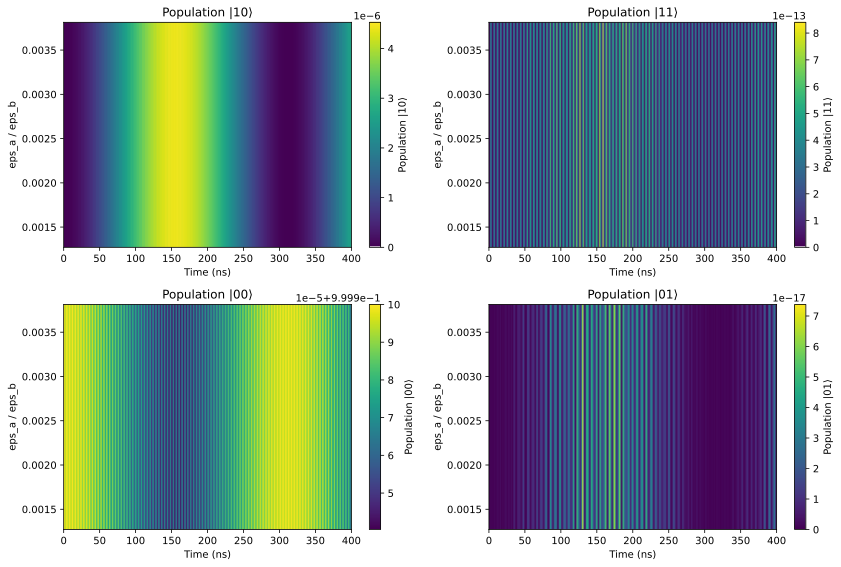

In [90]:

import scqubits as scq
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt

# --- Setup qubits and Hilbert space ---
qbta = scq.Fluxonium(
    EC=1.0617, EJ=4.1933, EL=.9336, flux=0.5, cutoff=110, truncated_dim=20,
)
qbtb = scq.Transmon(
    EJ=19.98, EC=0.1845, ng=0, ncut=110, truncated_dim=20
)
hilbertspace = scq.HilbertSpace([qbta, qbtb])
hilbertspace.add_interaction(
    g_strength=0.0222, op1=qbta.n_operator, op2=qbtb.n_operator,
)
hilbertspace.generate_lookup()

# --- Truncate operators ---
total_truncation = 15
def truncate(operator, dimension): return qt.Qobj(operator[:dimension, :dimension])
n_a = truncate(hilbertspace.op_in_dressed_eigenbasis(qbta.n_operator), total_truncation)
n_b = truncate(hilbertspace.op_in_dressed_eigenbasis(qbtb.n_operator), total_truncation)
(evals,) = hilbertspace["evals"]
diag_dressed_hamiltonian_trunc = truncate(
    2 * np.pi * qt.Qobj(np.diag(evals), dims=[hilbertspace.subsystem_dims]*2),
    total_truncation
)


# --- Get dressed indices for |11> and |10> ---
def get_idx(state_tuple):
    return hilbertspace.dressed_index(state_tuple)

idx_11 = get_idx((1,1))
idx_10 = get_idx((1,0))



# creating all the possible states for time evolution
product_states_unsorted = [(0, 0), (1, 0), (0, 1),(2,0), (1, 1),(0,3) , (2,1),(0,2),(3,0), (1,2),(2,1), (2,2)]
idxs_unsorted = [hilbertspace.dressed_index((s1, s2)) for (s1, s2) in product_states_unsorted]
paired_data = list(zip(idxs_unsorted, product_states_unsorted))
sorted_data = sorted(paired_data, key=lambda x: x[0])
product_states = [data[1] for data in sorted_data]
idxs = [data[0] for data in sorted_data]
states = [qt.basis(total_truncation, idx) for idx in idxs]

# --- Time list ---
tlist = np.linspace(0, 400, 400)

# --- SD condition ---

n_a_00_01 = n_a[hilbertspace.dressed_index((0,0)),hilbertspace.dressed_index((0,1))]
n_b_00_01 = n_b[hilbertspace.dressed_index((0,0)),hilbertspace.dressed_index((0,1))]
eta = -n_a_00_01/n_b_00_01 


ratios = np.linspace(.5*eta, 1.5*eta, 11)
# Hamiltonian: drive both n_a and n_b with relative amplitude ratio
drive_freq = (diag_dressed_hamiltonian_trunc.eigenenergies()[idx_11] -
                diag_dressed_hamiltonian_trunc.eigenenergies()[idx_10])
A = 0.5

# ...existing code up to the for loop...

# Prepare arrays to collect populations for |10>, |11>, |00>, |01>
idx_00 = get_idx((0, 0))
idx_01 = get_idx((0, 1))
idx_10 = get_idx((1, 0))
idx_11 = get_idx((1, 1))

pop_10_vs_ratio = np.zeros((len(ratios), len(tlist)))
pop_11_vs_ratio = np.zeros((len(ratios), len(tlist)))
pop_00_vs_ratio = np.zeros((len(ratios), len(tlist)))
pop_01_vs_ratio = np.zeros((len(ratios), len(tlist)))

for i, ratio in enumerate(ratios):
    eps_a = 1
    eps_b = eta
    def cosine_drive(t, args): return A * np.cos(2 * np.pi * drive_freq * t)
    H = [
        diag_dressed_hamiltonian_trunc,
        [2 * np.pi * (eps_a * n_a + eps_b * n_b), cosine_drive],
    ]
    result = qt.sesolve(
        H,
        qt.basis(total_truncation, idx_00),  # Start in |10>
        tlist,
        e_ops=[state * state.dag() for state in states]
    )
    # Find the indices in 'states' for |10>, |11>, |00>, |01>
    idx_10_in_states = [i for i, s in enumerate(product_states) if s == (1, 0)][0]
    idx_11_in_states = [i for i, s in enumerate(product_states) if s == (1, 1)][0]
    idx_00_in_states = [i for i, s in enumerate(product_states) if s == (0, 0)][0]
    idx_01_in_states = [i for i, s in enumerate(product_states) if s == (0, 1)][0]
    pop_10_vs_ratio[i, :] = result.expect[idx_10_in_states]
    pop_11_vs_ratio[i, :] = result.expect[idx_11_in_states]
    pop_00_vs_ratio[i, :] = result.expect[idx_00_in_states]
    pop_01_vs_ratio[i, :] = result.expect[idx_01_in_states]

# Plot the population evolution for each state as a function of ratio and time
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.imshow(pop_10_vs_ratio, aspect='auto', extent=[tlist[0], tlist[-1], float(ratios[0]), float(ratios[-1])], origin='lower')
plt.colorbar(label='Population |10⟩')
plt.xlabel('Time (ns)')
plt.ylabel('eps_a / eps_b')
plt.title('Population |10⟩')

plt.subplot(2, 2, 2)
plt.imshow(pop_11_vs_ratio, aspect='auto', extent=[tlist[0], tlist[-1], float(ratios[0]), float(ratios[-1])], origin='lower')
plt.colorbar(label='Population |11⟩')
plt.xlabel('Time (ns)')
plt.ylabel('eps_a / eps_b')
plt.title('Population |11⟩')

plt.subplot(2, 2, 3)
plt.imshow(pop_00_vs_ratio, aspect='auto', extent=[tlist[0], tlist[-1], float(ratios[0]), float(ratios[-1])], origin='lower')
plt.colorbar(label='Population |00⟩')
plt.xlabel('Time (ns)')
plt.ylabel('eps_a / eps_b')
plt.title('Population |00⟩')

plt.subplot(2, 2, 4)
plt.imshow(pop_01_vs_ratio, aspect='auto', extent=[tlist[0], tlist[-1], float(ratios[0]), float(ratios[-1])], origin='lower')
plt.colorbar(label='Population |01⟩')
plt.xlabel('Time (ns)')
plt.ylabel('eps_a / eps_b')
plt.title('Population |01⟩')

plt.tight_layout()
plt.show()
    
    




### Flux vs matrix elements

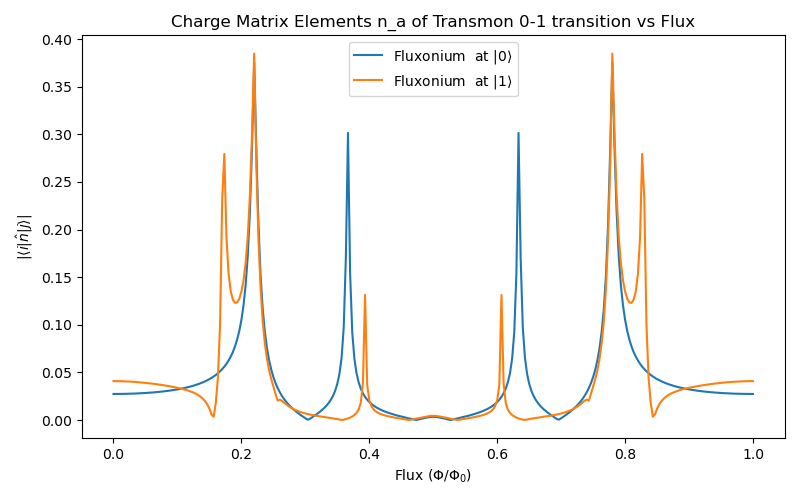

In [ ]:
%matplotlib widget
import scqubits as scq
import numpy as np
import matplotlib.pyplot as plt

# Sweep flux from 0 to 1
flux_vals = np.linspace(0, 1, 301)
n_a_00_01_list = []
n_a_10_11_list = []
n_a_00_01_list = []

# Fixed parameters
ECa, EJa, ELa = 1.0617, 4.19, 0.933
ECb, EJb = 0.1845, 19.98
cutoff, trunc = 110, 12

for flux in flux_vals:
    # Create qubits at this flux
    qbta = scq.Fluxonium(EC=ECa, EJ=EJa, EL=ELa, flux=flux, cutoff=cutoff, truncated_dim=trunc)
    qbtb = scq.Transmon(EJ=EJb, EC=ECb, ng=0, ncut=cutoff, truncated_dim=trunc)

    hilbertspace = scq.HilbertSpace([qbta, qbtb])
    hilbertspace.add_interaction(
        g_strength=0.0222, op1=qbta.n_operator, op2=qbtb.n_operator,
    )
    hilbertspace.generate_lookup()

    # --- Truncate operators ---
    total_truncation = 15
    def truncate(operator, dimension): return qt.Qobj(operator[:dimension, :dimension])
    n_a = truncate(hilbertspace.op_in_dressed_eigenbasis(qbta.n_operator), total_truncation)
    n_b = truncate(hilbertspace.op_in_dressed_eigenbasis(qbtb.n_operator), total_truncation)
    (evals,) = hilbertspace["evals"]
    diag_dressed_hamiltonian_trunc = truncate(
        2 * np.pi * qt.Qobj(np.diag(evals), dims=[hilbertspace.subsystem_dims]*2),
        total_truncation
    )


    # --- Get dressed indices for |11> and |10> ---
    def get_idx(state_tuple):
        return hilbertspace.dressed_index(state_tuple)

    idx_11 = get_idx((1,1))
    idx_10 = get_idx((1,0))
    idx_00 = get_idx((0, 0))
    idx_01 = get_idx((0, 1))
    # Matrix elements (absolute value)
    n_a_10_11 = abs(n_a[idx_11, idx_10])  # <(1,1)|n_a|(1,0)>
    n_a_00_01 = abs(n_a[idx_01, idx_00]) # <(0,1)|n_a|(0,0)>
    
    n_a_00_01_list.append(n_a_00_01)
    n_a_10_11_list.append(n_a_10_11)


plt.figure(figsize=(8,5))
plt.plot(flux_vals, n_a_00_01_list, label=r'Fluxonium  at $|0\rangle$')
plt.plot(flux_vals, n_a_10_11_list, label=r'Fluxonium  at $|1\rangle$')
plt.xlabel('Flux ($\Phi/\Phi_0$)')
plt.ylabel(r'$|\langle i|\hat{n}|j\rangle|$')
plt.title('Charge Matrix Elements n_a of Transmon 0-1 transition vs Flux')
plt.legend()
plt.tight_layout()
plt.show()